In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import random

from dataset import Tokenizer, build_names_dataset, TensorDataset
from lr_scheduler import ConstatntLr
from optim import SgdOptimizer
from train import train_step, train
from layers import Linear, LinearNormalized, LinearWithGain, Tanh
from plot_activations import plot_initialization_statistics
from model import MultiLayerPerceptron

%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Dataset preparation

The token we work with is a single character (for simplicity).
Our model will train to predict next token given previous context of 3 tokens (3-grams)

In [3]:
# read names
with open("names.txt", "r") as fnames:
    names = fnames.read().splitlines()
names_cnt = len(names)
print('names:')
for name in names[:5]:
    print(name)
print(f'total names count: {names_cnt}')

# building vocabulary and tokenizer
special_tokens = ['.']   # represents the start and the end of each name.
vocab = special_tokens + sorted(list(set(''.join(names))))
vocab_size = len(vocab)
tokenizer = Tokenizer(vocab)
print(f'{vocab=}')
print(f'{vocab_size=}')
print(tokenizer.encode("vlad"), tokenizer.decode([22,12,1,4]))

block_size = 3 # represents the length of context
random.shuffle(names)
train_bound = int(0.8*names_cnt)
val_bound   = int(0.9*names_cnt)
train_X, train_y = build_names_dataset(names[:train_bound], tokenizer, block_size)
val_X, val_y = build_names_dataset(names[train_bound:val_bound], tokenizer, block_size)
test_X, test_y = build_names_dataset(names[val_bound:], tokenizer, block_size)
print(f'{train_X.shape=}, {train_y.shape=}, {val_X.shape=}, {val_y.shape=}, {test_X.shape=}, {test_y.shape=}')
print("train:")
for i in range(13):
    print(f'{"".join(tokenizer.decode(train_X[i]))} => {tokenizer.itoc[train_y[i]]}')

train_ds = TensorDataset(train_X, train_y)
val_ds   = TensorDataset(val_X, val_y, device)

names:
emma
olivia
ava
isabella
sophia
total names count: 32033
vocab=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocab_size=27
[22, 12, 1, 4] ['v', 'l', 'a', 'd']
train_X.shape=torch.Size([182517, 3]), train_y.shape=torch.Size([182517]), val_X.shape=torch.Size([22857, 3]), val_y.shape=torch.Size([22857]), test_X.shape=torch.Size([22772, 3]), test_y.shape=torch.Size([22772])
train:
... => e
..e => m
.em => i
emi => l
mil => i
ili => e
lie => .
... => z
..z => i
.zi => n
zin => a
ina => c
nac => h


### Define evaluation

In [4]:
@torch.no_grad()
def evaluate(model, max_new_tokens=100):
    result = []
    context = torch.zeros((1, block_size)).to(torch.int64)
    for t in range(max_new_tokens):
        next_token = torch.multinomial(F.softmax(model(context), dim=1), 1)
        result.append(next_token)
        if next_token == 0:
            break
        context = context.roll(-1, dims=1)
        context[0, -1] = next_token
    return result

### Build multi-layer perceptron (MLP) model

here we are building something like "Bengio et al. 2003 A Neural Probabilistic Language Model" paper

model.nelement()=4433
init_t_loss=17.89508056640625, init_v_loss=17.86627197265625
epoch=0: cur_avg_train_loss=2.788549869207647, cur_val_loss=2.5300958156585693
maanlic.
craho.
ana.
anre.
enjea.
myan.
kin.
ongnry.
ral.
jal.
teji.
mayzan.
ajiia.
numenin.
jas.


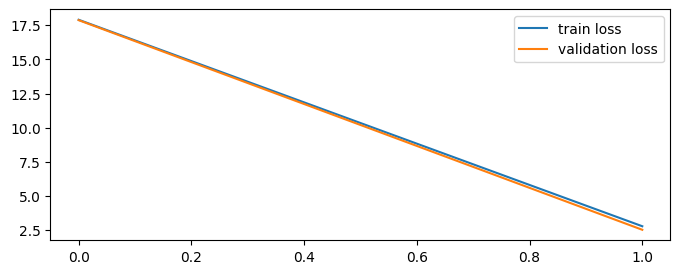

In [5]:
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=2, hidden_size=128, n_hidden=1, device=device)
lr_provider = ConstatntLr(0.1)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(model, train_ds, val_ds, epoches=1, batch_size=64, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

for i in range(15):
    print(''.join(tokenizer.decode(evaluate(model, max_new_tokens=1000))))

### Visualize 2D embeddings

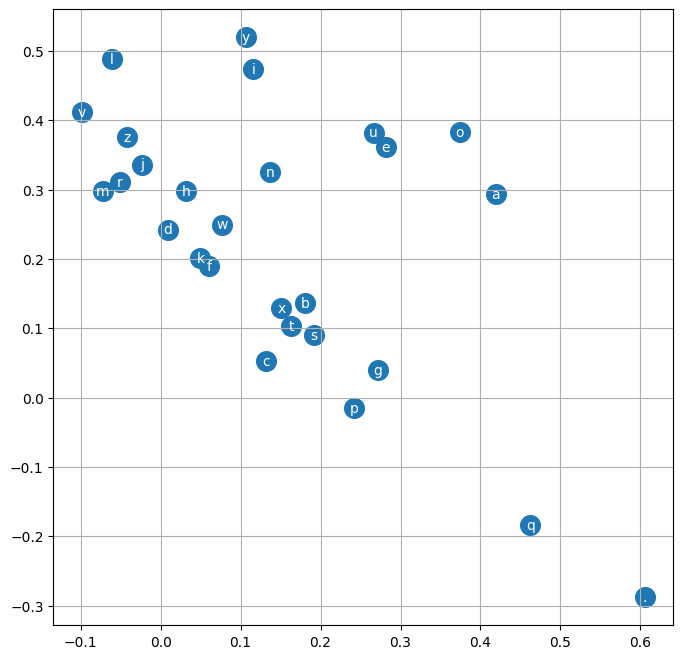

In [6]:
# visualize dimensions 0 and 1 of the embedding matrix model.emb for all characters
plt.figure(figsize=(8,8))
C = model.emb.cpu()
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), tokenizer.itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

### Scale-up the model: add neurons to single layer

model384.nelement()=22569
init_t_loss=35.01706314086914, init_v_loss=34.821868896484375
epoch=0: cur_avg_train_loss=4.787069312151819, cur_val_loss=3.212982177734375
adan.
tno.
aia.
ati.
anu.
soo.
ayurroska.
son.
yionnie.
ato.


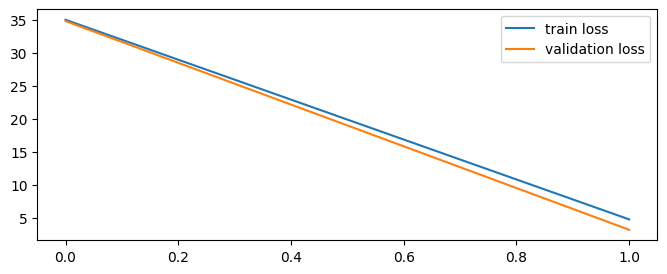

In [7]:
model384 = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=384, n_hidden=1, device=device)
lr_provider = ConstatntLr(0.1)
optimizer   = SgdOptimizer(model384.parameters(), lr_provider)
print(f'{model384.nelement()=}')

init_t_loss = F.cross_entropy(model384(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model384(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")


t_loss, v_loss = train(model384, train_ds, val_ds, epoches=1, batch_size=64, optimizer=optimizer,device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

for i in range(10):
    print(''.join(tokenizer.decode(evaluate(model384, max_new_tokens=1000))))


3.196692943572998


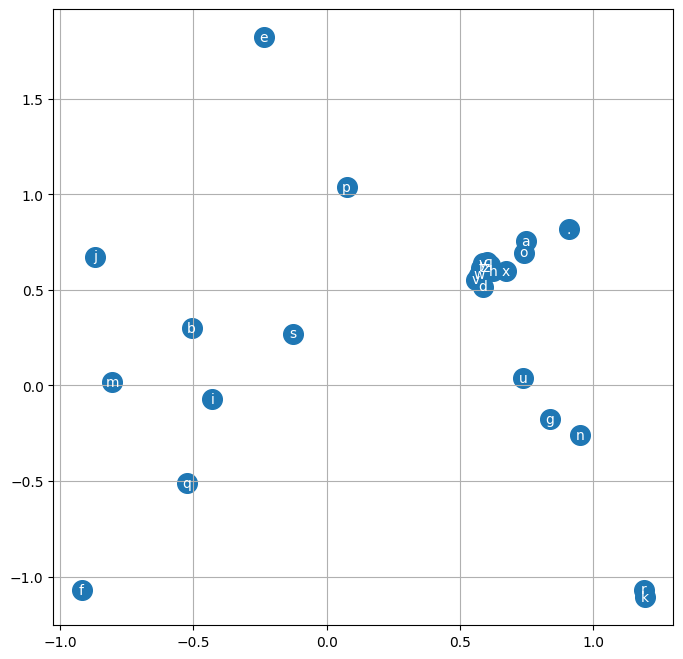

In [8]:
# visualize some 2 dimensions of the embedding matrix model384.emb for all characters
plt.figure(figsize=(8,8))
C = model384.emb.cpu()
dim1, dim2 = 4, 5
plt.scatter(C[:, dim1].data, C[:, dim2].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, dim1].item(), C[i, dim2].item(), tokenizer.itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

with torch.no_grad():
    test_logits = model384(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss}')

### Build pyTorch-like model classes 

model.nelement()=73769
init_t_loss=22.199966430664062, init_v_loss=22.292980194091797
layer 1 (      Tanh): mean +0.04, std 0.93, saturated: 70.38%
layer 3 (      Tanh): mean +0.02, std 0.96, saturated: 84.90%
layer 5 (      Tanh): mean +0.02, std 0.96, saturated: 84.62%
layer 7 (      Tanh): mean -0.02, std 0.96, saturated: 84.12%
layer 9 (      Tanh): mean -0.01, std 0.96, saturated: 85.30%
Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean -0.015043, std 8.964852e-01
layer 3 (      Tanh): mean +0.000401, std 3.278122e-01
layer 5 (      Tanh): mean -0.002305, std 1.373665e-01
layer 7 (      Tanh): mean -0.000260, std 5.233401e-02
layer 9 (      Tanh): mean -0.000231, std 2.093225e-02
weight   (27, 10) | mean +0.295020 | std 8.765932e+00 | grad:data ratio 8.702158e+00
weight  (30, 128) | mean -0.050230 | std 2.319817e+00 | grad:data ratio 2.318870e+00
weight (128, 128) | mean +0.002695 | std 6.194926e-01 | grad:data ratio 6.107396e-01
weight (128, 128) | 

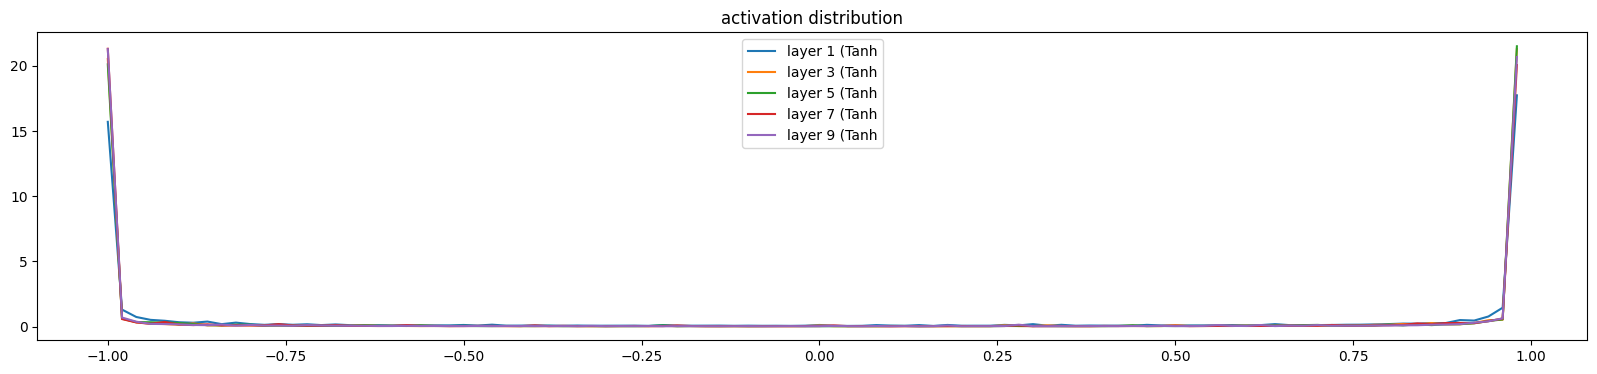

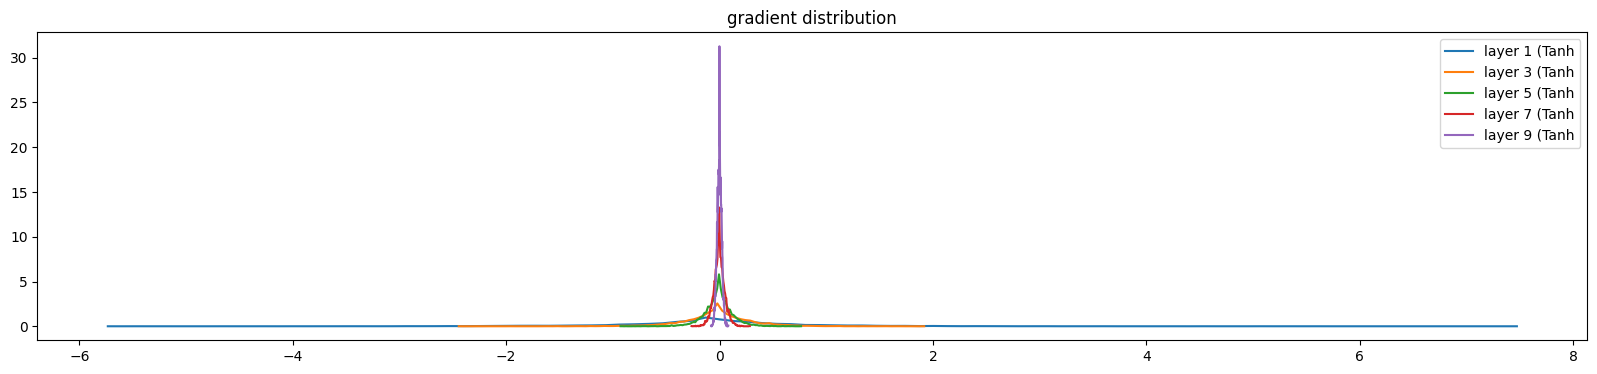

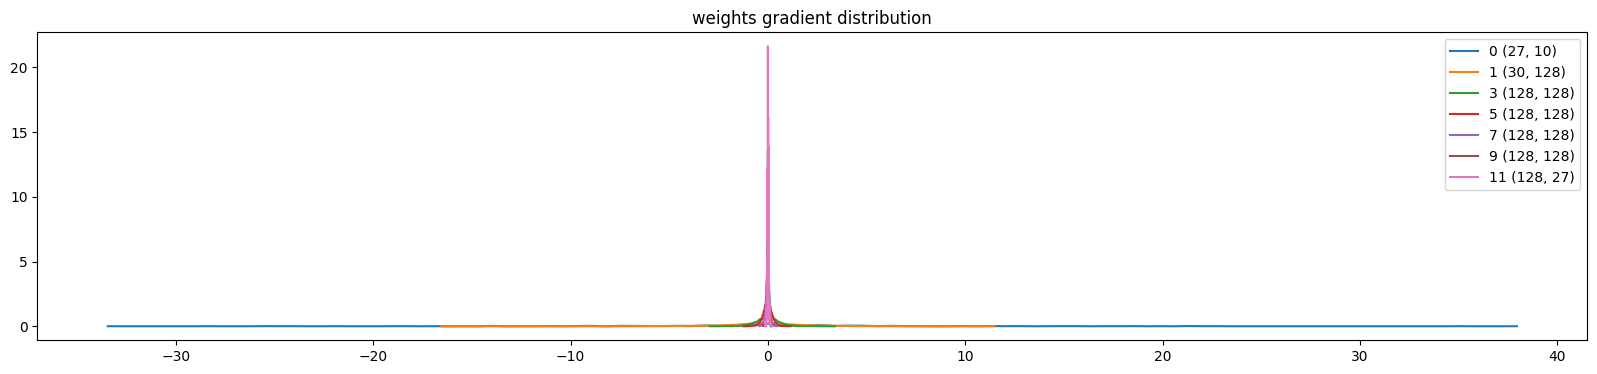

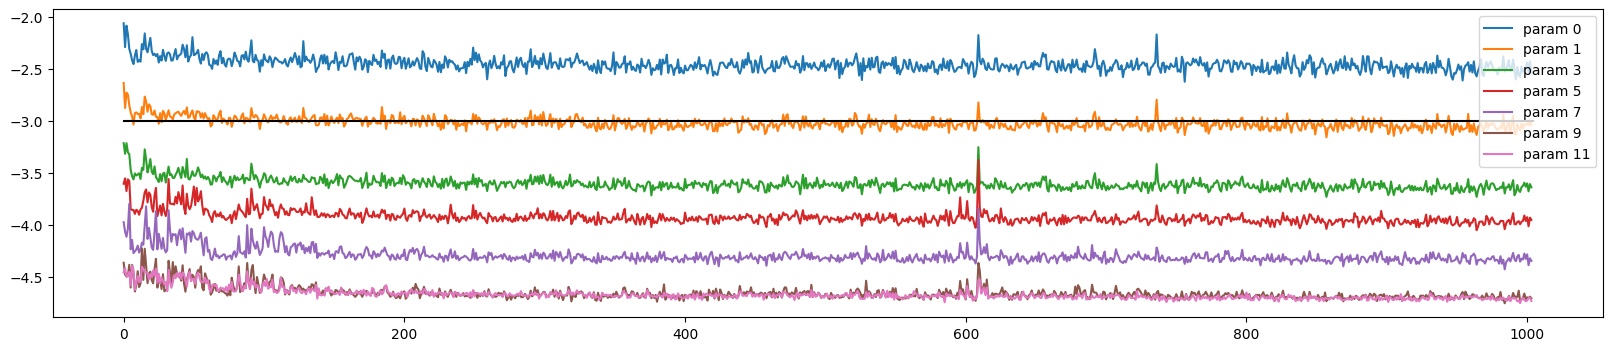

In [9]:
g = torch.Generator(device=device).manual_seed(7877)

model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, keep_intermediate_grad=True, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

plot_initialization_statistics(model, optimizer, train_ds, val_ds, device=device)

- Given the plot above we see that randomly initialized weights produce almost saturated tanh activations, so gradient signal on backward pass will be to small to learn effectively.
- On the plot above we see the spreading of gradient distribution from last to very first layer (as a result of saturated tanh). It makes first layers difficult to learn as they get small gradient signal. It is called 'gradient vanishing'
- Weights gradients are not well distributed as well. Last layers have about 10 times bigger gradients, so they learn 10 times faster in the beginning
- Last plot represents update to weight ratio in logarithmic scale. This ratio represents "how big is the value we use to change weight comparing with weight itself". Good value for that ratio is approx -3. Current plot shows at least 4 last parameters which have 10000 times smaller update value in comparison to weight value.

### Final training of model w/o sophisticated initialization

model.nelement()=73769
init_t_loss=24.34820556640625, init_v_loss=24.456867218017578
epoch=0: cur_avg_train_loss=16.2662532403248, cur_val_loss=13.373851776123047


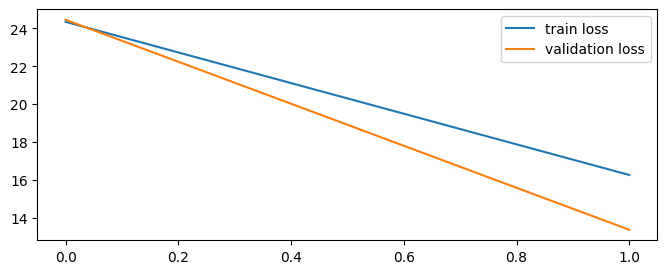

In [10]:
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(model, train_ds, val_ds, epoches=1, batch_size=182, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [11]:
for i in range(15):
    print(''.join(tokenizer.decode(evaluate(model, max_new_tokens=1000))))
    
with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss=}')

tsfviouqvigjihcksbewu.
cawaolewkmgsfuqxwxqqnohndpjsfkrkhje.
qctyywndfcfhconfach.
javoawbdfusijwrwnjtlv.
cawaolewkmfichjtfsidwaggziogy.
joynn.
tsfviomzyiftkhxqogmihdrqf.
tsfvko.
jav.
jamwdjctwwzjefcbomk.
joynn.
comijuwugrpbhbni.
cawahe.
xkigwoiofjnmtrvbq.
capzdeykiiexmfmqqfveryyuguiigynn.

test_loss=tensor(13.3508)


### Normalize weights in Linear layer

model.nelement()=73769
init_t_loss=3.324488639831543, init_v_loss=3.3254904747009277
layer 1 (      Tanh): mean +0.07, std 0.71, saturated: 12.22%
layer 3 (      Tanh): mean +0.03, std 0.68, saturated: 7.71%
layer 5 (      Tanh): mean +0.06, std 0.70, saturated: 9.64%
layer 7 (      Tanh): mean -0.03, std 0.70, saturated: 8.52%
layer 9 (      Tanh): mean -0.10, std 0.63, saturated: 5.06%
Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean +0.000002, std 2.017920e-04
layer 3 (      Tanh): mean +0.000013, std 3.181649e-04
layer 5 (      Tanh): mean -0.000003, std 5.453713e-04
layer 7 (      Tanh): mean -0.000032, std 9.017166e-04
layer 9 (      Tanh): mean -0.000007, std 1.369595e-03
weight   (27, 10) | mean -0.000099 | std 7.616740e-04 | grad:data ratio 7.818122e-04
weight  (30, 128) | mean -0.000030 | std 1.093571e-03 | grad:data ratio 5.987241e-03
weight (128, 128) | mean +0.000017 | std 1.852246e-03 | grad:data ratio 2.065970e-02
weight (128, 128) | mean 

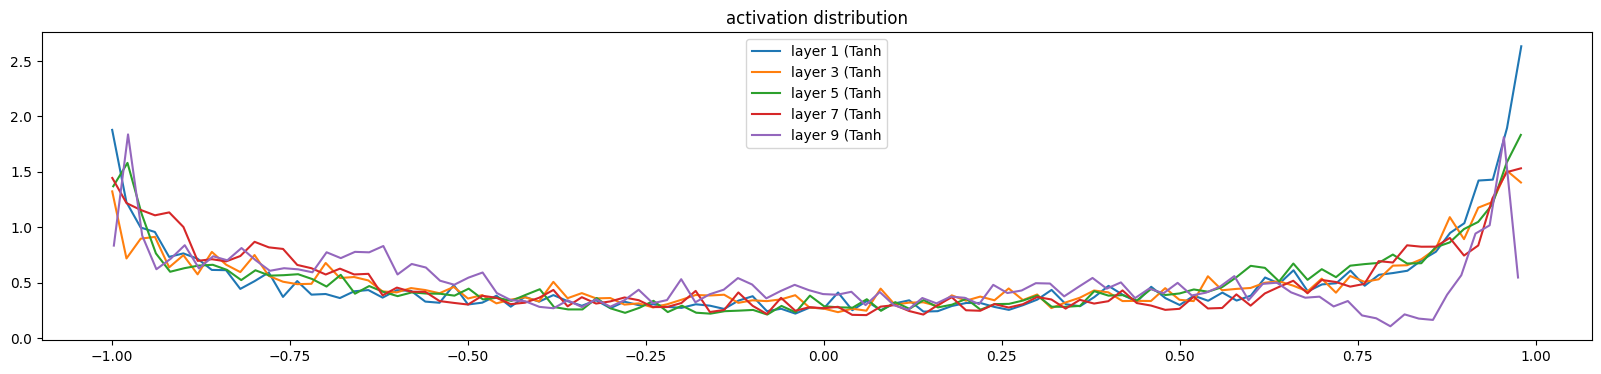

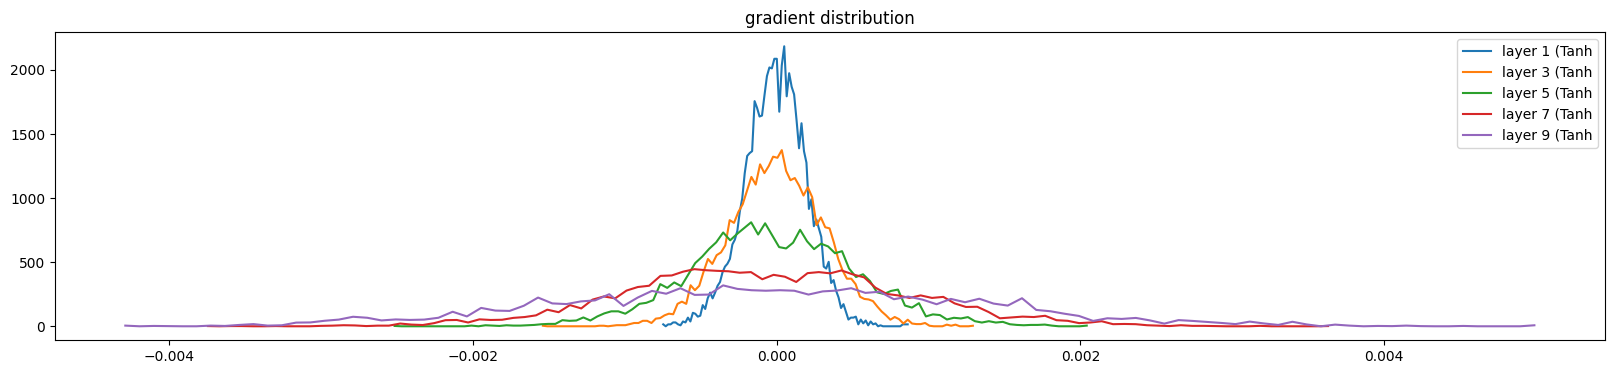

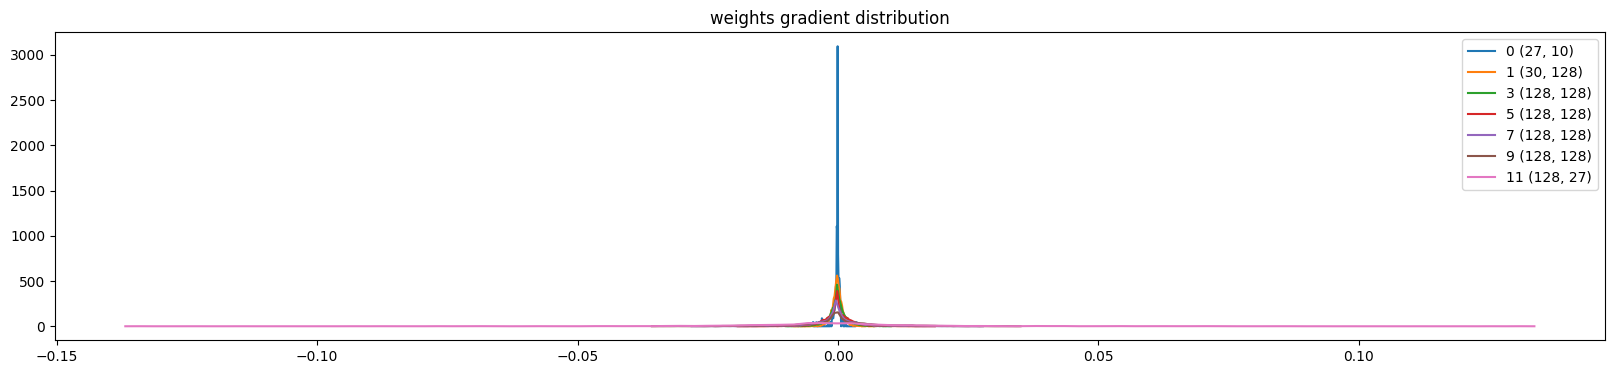

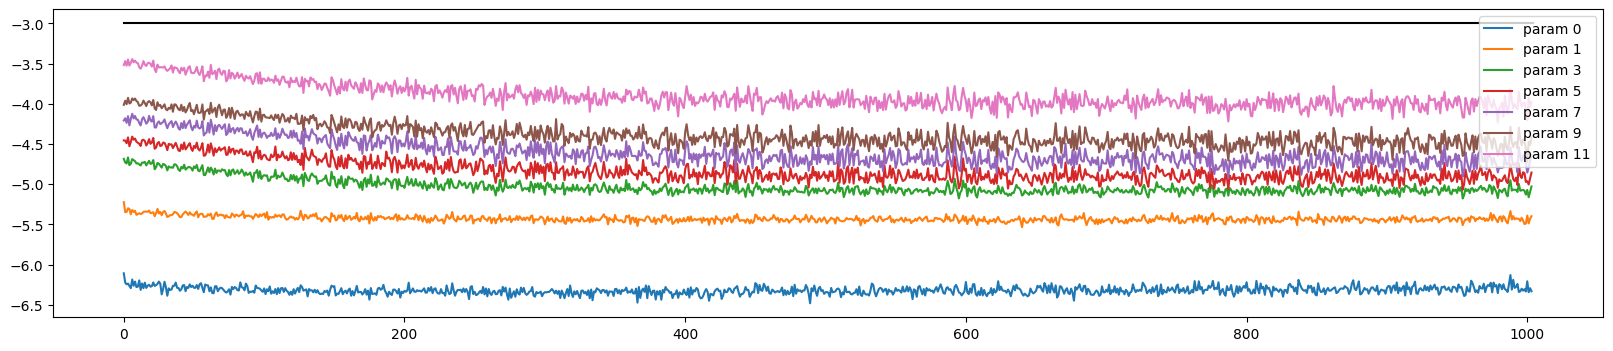

In [12]:
g = torch.Generator(device=device).manual_seed(7877)
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, linear_layer=LinearNormalized, keep_intermediate_grad=True, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")
plot_initialization_statistics(model, optimizer, train_ds, val_ds, device=device)

- Now activations on tanh not so saturated as before normalization.
- Gradients become better at first layers
- Weights gradients are not well distributed still
- Update to weight ratio become worser. we need to apply more sophisticated initialization

model.nelement()=73769
init_t_loss=3.739030122756958, init_v_loss=3.7363710403442383
epoch=0: cur_avg_train_loss=2.947910808970184, cur_val_loss=2.820645570755005


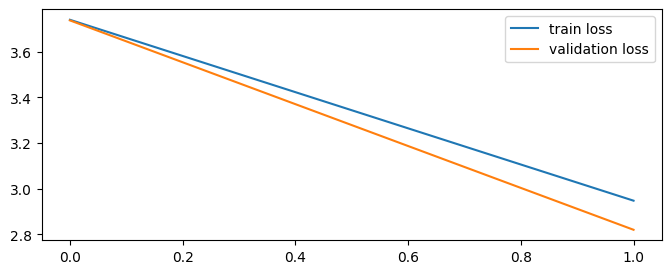

In [13]:
# Train model with normalized weights in linear layers
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, linear_layer=LinearNormalized, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train(model, train_ds, val_ds, epoches=1, batch_size=182, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

- After adding single initialization feature we see much better results in training 

In [14]:
for i in range(15):
    print(''.join(tokenizer.decode(evaluate(model, max_new_tokens=1000))))

with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss=}')

eaajmlciff.
n.
l.
eou.
.
yemyllain.
ijotcn.
asboyli.
jnyihai.
akfakenollaa.
.
lotceooiua.
yruwhn.
a.
ldhi.

test_loss=tensor(2.8311)


### Complete calculating the init scale (Kaiming init): adding gain
- for details: 'Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015)'
- concept: At initialization we want to maintain distribution of activations on each layer with same mean and std. Its is can be done by initialization of linear layer weights by sampling N(0,std^2) where std = gain/sqrt(in_features)

model.nelement()=73769
init_t_loss=3.77766489982605, init_v_loss=3.783857583999634
layer 1 (      Tanh): mean +0.06, std 0.77, saturated: 24.21%
layer 3 (      Tanh): mean +0.04, std 0.75, saturated: 18.46%
layer 5 (      Tanh): mean +0.06, std 0.75, saturated: 19.31%
layer 7 (      Tanh): mean -0.06, std 0.76, saturated: 21.45%
layer 9 (      Tanh): mean -0.10, std 0.72, saturated: 17.84%
Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean -0.000010, std 1.904535e-03
layer 3 (      Tanh): mean +0.000058, std 2.036160e-03
layer 5 (      Tanh): mean -0.000015, std 2.185179e-03
layer 7 (      Tanh): mean -0.000177, std 2.371506e-03
layer 9 (      Tanh): mean -0.000064, std 2.406324e-03
weight   (27, 10) | mean +0.000583 | std 1.015750e-02 | grad:data ratio 1.028028e-02
weight  (30, 128) | mean -0.000035 | std 8.845627e-03 | grad:data ratio 2.905758e-02
weight (128, 128) | mean +0.000152 | std 9.183705e-03 | grad:data ratio 6.146027e-02
weight (128, 128) | mea

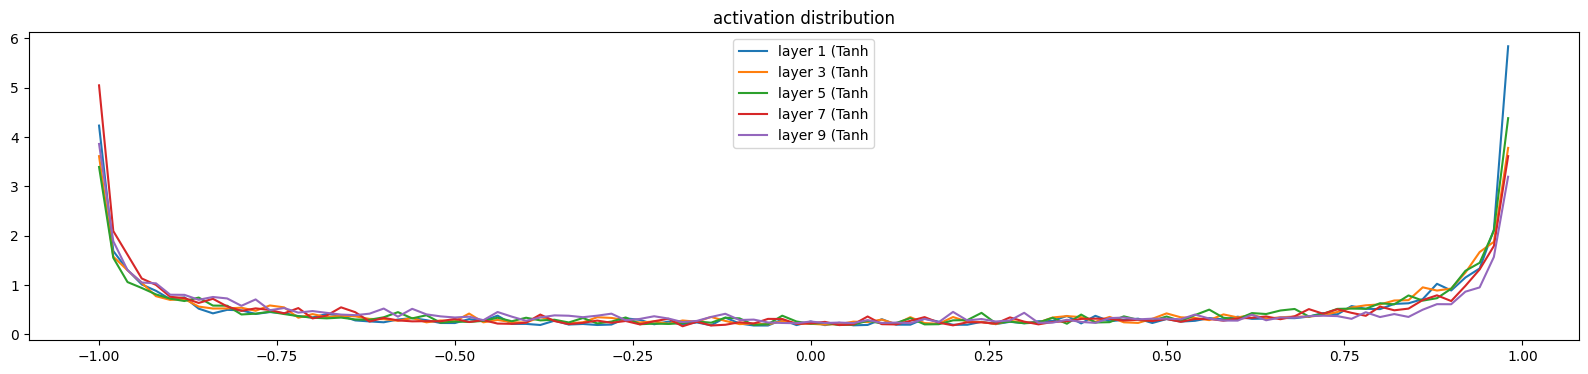

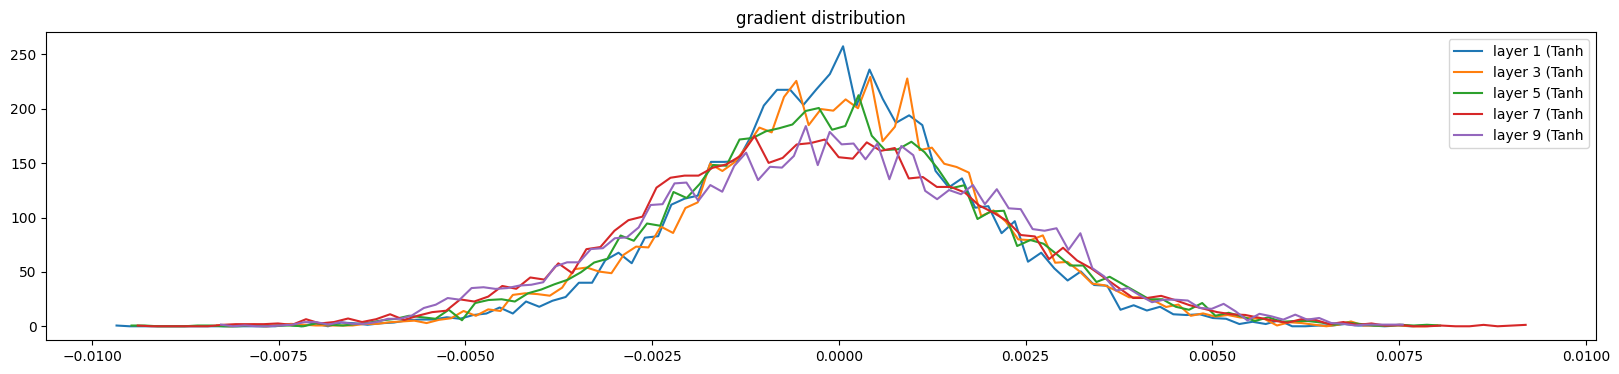

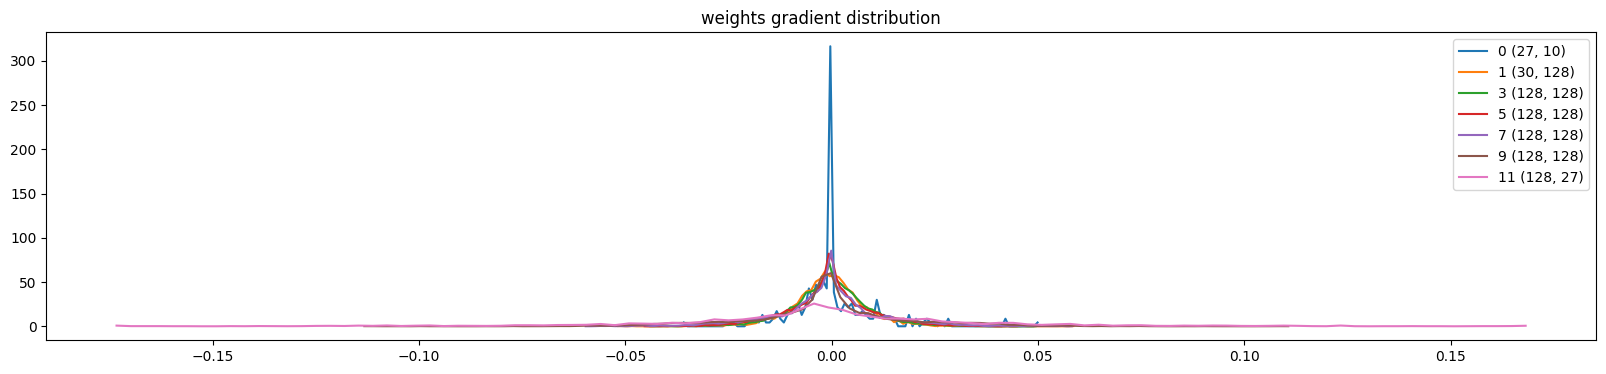

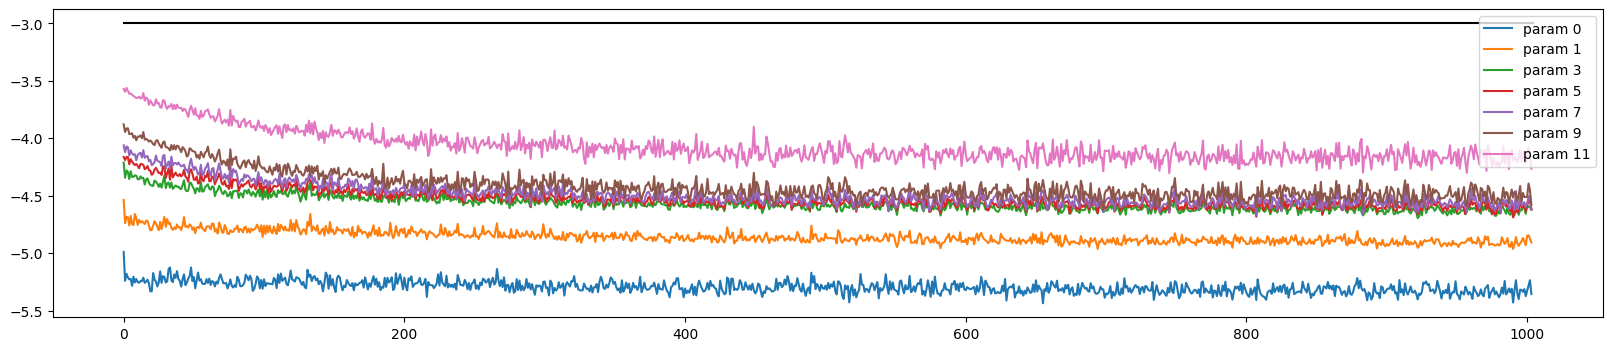

In [15]:
g = torch.Generator(device=device).manual_seed(7877)
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, linear_layer=LinearWithGain, keep_intermediate_grad=True, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")
plot_initialization_statistics(model, optimizer, train_ds, val_ds, device=device)

- Slightly hight satturation in the begining
- Gradients per layer distributed very well
- Weights gradients are good enougth
- We see that whatever the initialization feature we apply the update:weight ratio still not good enougth. That indicates that we should increase learining rate to make this ratio arrount -3

model.nelement()=73769
init_t_loss=3.7767930030822754, init_v_loss=3.7757532596588135
epoch=0: cur_avg_train_loss=2.952464847241418, cur_val_loss=2.8177146911621094


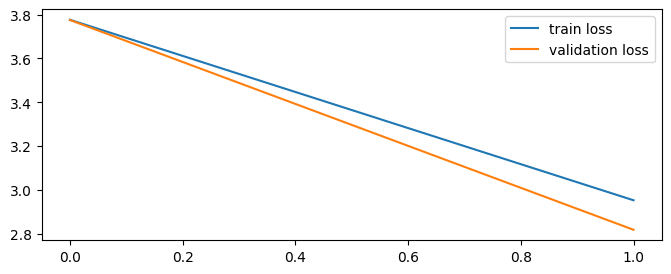

In [16]:
# Train model with normalized weights in linear layers
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, linear_layer=LinearNormalized, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train(model, train_ds, val_ds, epoches=1, batch_size=182, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [17]:
for i in range(15):
    print(''.join(tokenizer.decode(evaluate(model, max_new_tokens=1000))))

with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss=}')

lksilizden.
iaiyel.
ydahtz.
pmiairg.
tmb.
k.
vieydai.
elassvajiianbooilnyienndniiztaliienfnjrush.
as.
cqzdyanalaydqlabnhie.
frahnad.
a.
ahnocnhavye.
eri.
i.

test_loss=tensor(2.8260)


- Slightly better results on test dataset and in training. Generated samples looks as bad as in previous model

### Increase learning rate

- given update:weight ratio plots we see that learning rate can be increased slightly to make update:weight = 1:1000
- according to last plot we can make a learning_rate for last model 10-100 times bigger

model.nelement()=73769
init_t_loss=3.853200674057007, init_v_loss=3.8663103580474854
layer 1 (      Tanh): mean -0.00, std 0.79, saturated: 29.18%
layer 3 (      Tanh): mean +0.02, std 0.75, saturated: 19.76%
layer 5 (      Tanh): mean +0.06, std 0.75, saturated: 19.87%
layer 7 (      Tanh): mean -0.05, std 0.77, saturated: 20.73%
layer 9 (      Tanh): mean -0.09, std 0.73, saturated: 18.48%
Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean +0.000020, std 1.784323e-03
layer 3 (      Tanh): mean +0.000079, std 1.831067e-03
layer 5 (      Tanh): mean +0.000026, std 2.055309e-03
layer 7 (      Tanh): mean -0.000134, std 2.267533e-03
layer 9 (      Tanh): mean -0.000064, std 2.361557e-03
weight   (27, 10) | mean -0.000649 | std 9.496728e-03 | grad:data ratio 9.127262e-03
weight  (30, 128) | mean -0.000138 | std 9.468564e-03 | grad:data ratio 3.110330e-02
weight (128, 128) | mean -0.000030 | std 9.098644e-03 | grad:data ratio 6.089091e-02
weight (128, 128) | m

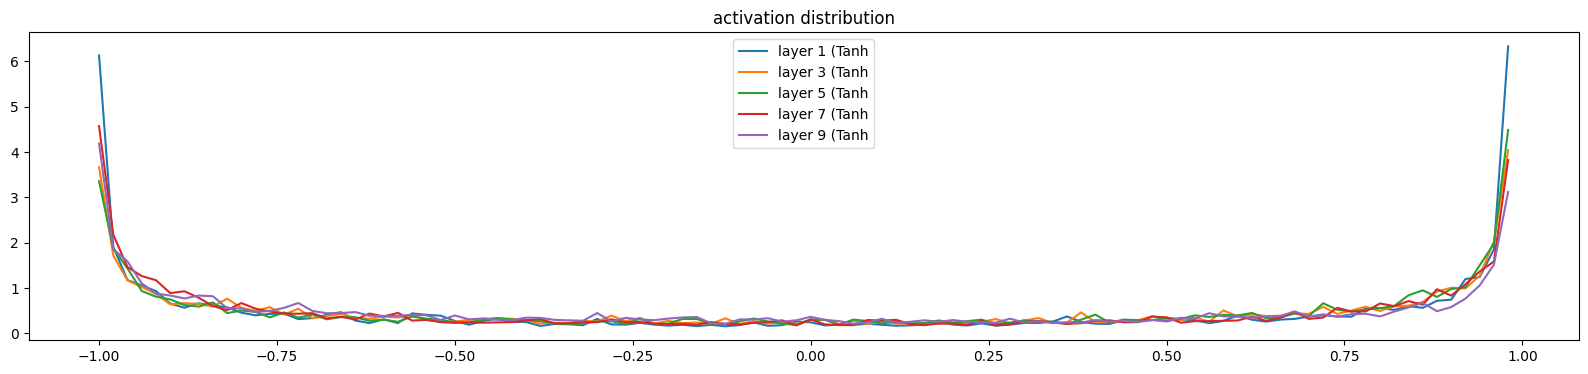

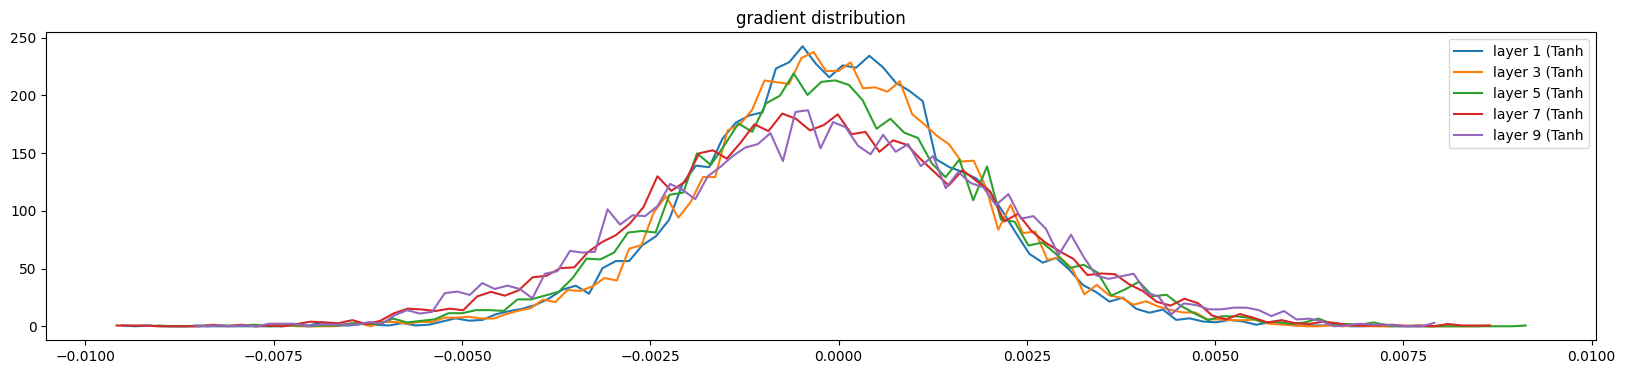

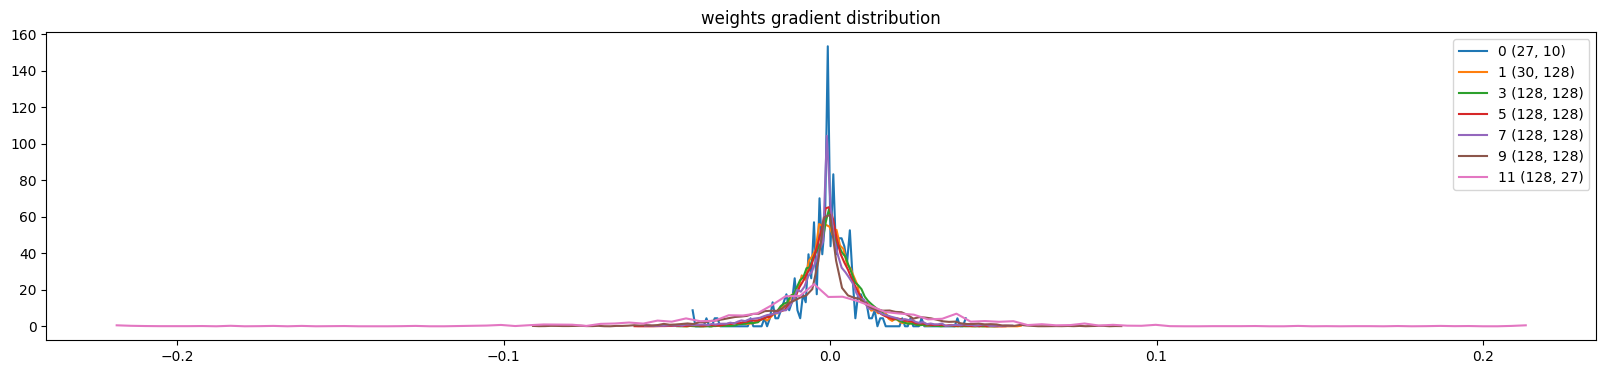

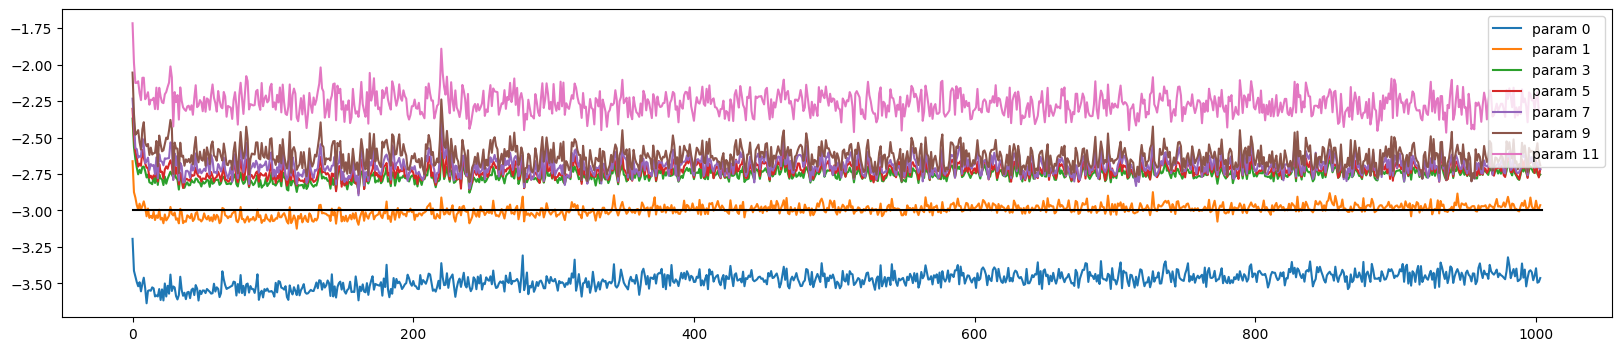

In [18]:
g = torch.Generator(device=device).manual_seed(7877)
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, linear_layer=LinearWithGain, keep_intermediate_grad=True, device=device, gen=g)
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

plot_initialization_statistics(model, optimizer, train_ds, val_ds, device=device)

- After few manual runs I found that 7e-2 Is a good one, so it 70 times bigger than previous value

model.nelement()=73769
init_t_loss=3.7452311515808105, init_v_loss=3.7430553436279297
epoch=0: cur_avg_train_loss=2.512728562027008, cur_val_loss=2.368448257446289


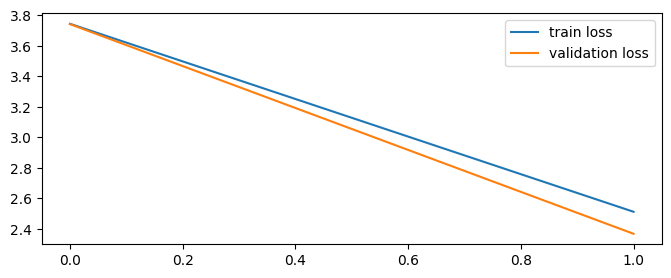

In [19]:
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, linear_layer=LinearNormalized, device=device, gen=g)
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train(model, train_ds, val_ds, epoches=1, batch_size=182, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [20]:
for i in range(15):
    print(''.join(tokenizer.decode(evaluate(model, max_new_tokens=1000))))

with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss=}')

nak.
rev.
leocson.
suienae.
efyryetan.
jahia.
edine.
kanoqia.
tazizeyecsa.
berbekahiah.
lai.
cno.
bryn.
zinacrriya.
jayvi.

test_loss=tensor(2.3640)


- Last samples are nice, loss values are the best

### Decrease last layer weights to make initial prediction probability uniform

- Loss at the beginning may take 10-100 times bigger value than at other learning steps.
- We actually want to initialize our NN to the state so all classes are equally distibuted => logits are close to each other
- to achieve this we can decrease last layer weights and biases to small values

In [21]:
# in case of equaly distributed 27 classes (next token) we would expect 1/27 prob of each, so the loss is:
expected_initial_loss = -torch.tensor(1/27).log() # negative log likelihood
expected_initial_loss

tensor(3.2958)

model.nelement()=73769
init_t_loss=3.2964794635772705, init_v_loss=3.296663522720337
epoch=0: cur_avg_train_loss=2.4632330708584544, cur_val_loss=2.3254153728485107


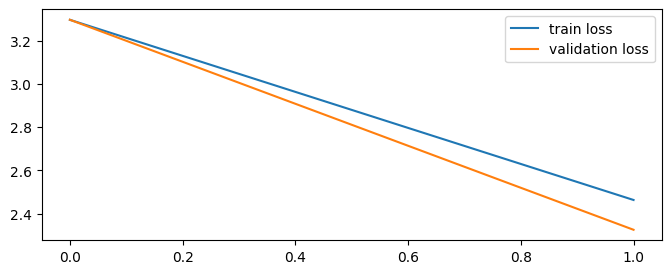

In [22]:
model = MultiLayerPerceptron(vocab_size, block_size, emb_size=10, hidden_size=128, n_hidden=5, linear_layer=LinearWithGain, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train(model, train_ds, val_ds, epoches=1, batch_size=182, optimizer=optimizer, device=device)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [23]:
for i in range(15):
    print(''.join(tokenizer.decode(evaluate(model, max_new_tokens=1000))))

with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss=}')

moryah.
sitle.
ashaysarnie.
nah.
wom.
vury.
cayti.
ristd.
jvahreniv.
von.
anmelyn.
jaryanouriy.
ahis.
dahhujeshyo.
sam.

test_loss=tensor(2.3242)
